In [1]:
#import libraries
import pandas as pd
from pandasql import sqldf 
import numpy as np
import stata_setup

#set up SQL and STATA integration
pysqldf = lambda q: sqldf(q, globals())
stata_setup.config("/Applications/Stata", "se")


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: 120-user network perpetual
Serial number: 401706334828
  Licensed to: Research, Teaching, and Learning
               Dartmouth College

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
#global variables 
pathtoData = '/Users/zacharywong/github/zacharywong2023/GreenWaves_in_SF_Analysis_Python_STATA/RawData/'
pathtoDeliverables = '/Users/zacharywong/github/zacharywong2023/GreenWaves_in_SF_Analysis_Python_STATA/PreparedData/'

In [3]:
# import bicycle count data in pandas dataframe 
bicycleCountData= 'Bike_Volume_-_Manual_Counts.csv' 
df = pd.read_csv(pathtoData + bicycleCountData)
df.head()


# reorder columns and delete unused columns 
df['YR2012_PM'] = np.nan
cols = df.columns.tolist()
del(cols[0:2])
del(cols[1:4])
del(cols[-7:])
del(cols[-4:-2])
df = df[cols]
df.head()

,LOCATION,YR2006_PM,YR2007_PM,YR2008_PM,YR2009_PM,YR2010_PM,YR2011_PM,YR2013_PM,YR2014_PM,YR2015_PM,YR2016_PM,YR2017_PM
0,22nd St & Folsom St,-1,-1,-1,-1,-1,-1,275.0,275.0,365,-1,-1
1,22nd St & Valencia St,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1
2,Polk St & Sutter St,158,181,209,203,258,336,432.0,432.0,446,481,367
3,Geneva Ave & Ocean Ave,-1,-1,-1,-1,-1,-1,64.0,64.0,85,-1,-1
4,Silver Ave & San Bruno Ave,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1


In [4]:
# Only keep locations that have sufficient data 
sfDF = df[(df['YR2006_PM'] > -1) & (df['YR2016_PM'] > -1)] 
sfDF.head()

,LOCATION,YR2006_PM,YR2007_PM,YR2008_PM,YR2009_PM,YR2010_PM,YR2011_PM,YR2013_PM,YR2014_PM,YR2015_PM,YR2016_PM,YR2017_PM
2,Polk St & Sutter St,158,181,209,203,258,336,432.0,432.0,446,481,367
5,Valencia St & 17th St,441,541,690,606,771,1059,1285.0,1285.0,1219,1169,1073
13,2nd St & Townsend,101,107,140,133,129,233,413.0,413.0,485,576,490
20,Marina Blvd & Cervantes Blvd,240,292,490,517,382,625,613.0,613.0,580,522,460
26,Polk St & McAllister St,223,266,295,309,311,497,680.0,680.0,668,819,751


In [5]:
# Use SQL to aggregate data by column
q = """SELECT Sum(YR2006_PM) as YR_2006, Sum(YR2007_PM) as YR_2007, Sum(YR2008_PM) as YR_2008, Sum(YR2009_PM) as YR_2009, 
        Sum(YR2010_PM) as YR_2010, Sum(YR2011_PM) as YR_2011, Sum(YR2013_PM) as YR_2013, Sum(YR2014_PM) as YR_2014, 
        Sum(YR2015_PM) as YR_2015, Sum(YR2016_PM) as YR_2016, Sum(YR2017_PM) as YR_2017
        From sfDF
    """ 
df = pysqldf(q)

# Rotate datatable and rename columns
dfBC = df.T.reset_index()
dfBC.columns = ['Count_Year', 'Bicycle_Count']
dfBC

,Count_Year,Bicycle_Count
0,YR_2006,4282.0
1,YR_2007,4623.0
2,YR_2008,6170.0
3,YR_2009,6469.0
4,YR_2010,6639.0
5,YR_2011,10483.0
6,YR_2013,11010.0
7,YR_2014,11010.0
8,YR_2015,10655.0
9,YR_2016,11547.0


In [6]:
# Read in bicycle parking availability data 
bicycleCountData= 'Bicycle_Parking.csv' 
df = pd.read_csv(pathtoData + bicycleCountData)
df

# clean up table (only keep spaces and install_year)
cols = df.columns.tolist()
del cols[0:6]
del cols[-12:]
del cols[1]
df = df[cols]
df.head()

,SPACES,INSTALL_YR
0,2,2004
1,0,0
2,2,2015
3,4,2010
4,2,2011


In [7]:
# use sql to group by year and order by year 
q = """ SELECT INSTALL_YR as Year, SUM(SPACES) as Spaces
        FROM df
        WHERE INSTALL_YR >= 2006 AND INSTALL_YR <= 2017 AND INSTALL_YR != 2012
        GROUP BY INSTALL_YR
        ORDER BY INSTALL_YR
    """
parkSFDF = pysqldf(q)
parkSFDF

,Year,Spaces
0,2006,284
1,2007,41
2,2008,88
3,2009,46
4,2010,1292
5,2011,688
6,2013,1127
7,2014,405
8,2015,2101
9,2016,706


In [8]:
# join data sets and prepare for STATA analysis
df = parkSFDF.join(dfBC, how='outer').drop(['Count_Year'], axis = 1)
df = df[['Year', 'Bicycle_Count', 'Spaces']]
df.set_index(['Year'])
fileName = 'SFData.csv'
df.to_csv(pathtoDeliverables + fileName)

In [9]:
%%stata
// generate post dummy variable 

insheet using "/Users/zacharywong/github/zacharywong2023/GreenWave/PreparedData/SFData.csv", comma clear
generate post = (year>=2011)


. // generate post dummy variable 
. 
. insheet using "/Users/zacharywong/github/zacharywong2023/GreenWave/PreparedDa
> ta/SFData.csv", comma clear
(4 vars, 11 obs)

. generate post = (year>=2011)

. 


In [10]:
%%stata
//create solo graph of bicycle count per year 

regress bicycle_count year spaces


. //create solo graph of bicycle count per year 
. 
. regress bicycle_count year spaces

      Source |       SS           df       MS      Number of obs   =        11
-------------+----------------------------------   F(2, 8)         =     22.92
       Model |  69357570.9         2  34678785.4   Prob > F        =    0.0005
    Residual |  12102643.8         8  1512830.48   R-squared       =    0.8514
-------------+----------------------------------   Adj R-squared   =    0.8143
       Total |  81460214.7        10  8146021.47   Root MSE        =      1230

------------------------------------------------------------------------------
bicycle_co~t | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
        year |   707.6565   130.2095     5.43   0.001     407.3929     1007.92
      spaces |  -.1030588   .7681104    -0.13   0.897    -1.874324    1.668207
       _cons |   -1414831   261577.2    


. // Create combination graph of control and post dummy variable
. 
. set scheme s1mono

. grstyle init

. grstyle set graphsize 6cm 10cm

. twoway (lfit bicycle_count year if year <= 2010) (lfit bicycle_count year if 
> year >= 2011) (lfit spaces year ) ///
> (scatter bicycle_count spaces year), xline(2010.5) title("Bicycle Counts and 
> Rack Spaces from 2006 - 2017") ///
> legend(order(4 "Bicycle Count" 5 "Bicycle Rack Spaces")) 

. 


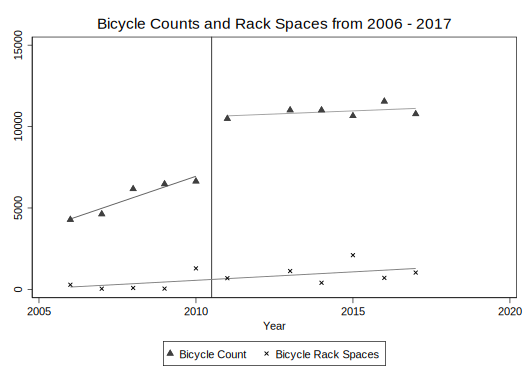

In [11]:
%%stata
// Create combination graph of control and post dummy variable

set scheme s1mono
grstyle init
grstyle set graphsize 6cm 10cm
twoway (lfit bicycle_count year if year <= 2010) (lfit bicycle_count year if year >= 2011) (lfit spaces year ) ///
(scatter bicycle_count spaces year), xline(2010.5) title("Bicycle Counts and Rack Spaces from 2006 - 2017") ///
legend(order(4 "Bicycle Count" 5 "Bicycle Rack Spaces")) 


. //Create solo graph of control variable per year 
. 
. grstyle init

. grstyle set graphsize 6cm 10cm

. twoway (lfit spaces year if year <= 2010) (lfit spaces year if year >= 2011) 
>  ///
> (scatter spaces year), xline(2010.5) ytitle("Rack Spaces") title("Bicycle Rac
> k Spaces from 2006 - 2017") ///
> legend(off) 

. 


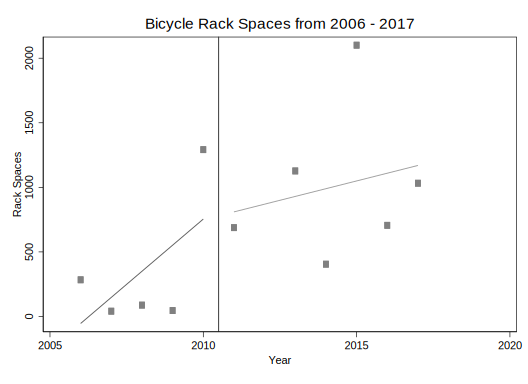

In [12]:
%%stata
//Create solo graph of control variable per year 

grstyle init
grstyle set graphsize 6cm 10cm
twoway (lfit spaces year if year <= 2010) (lfit spaces year if year >= 2011)  ///
(scatter spaces year), xline(2010.5) ytitle("Rack Spaces") title("Bicycle Rack Spaces from 2006 - 2017") ///
legend(off) 


. //create solo graph of bicycle count per year 
. 
. grstyle init

. grstyle set graphsize 6cm 10cm

. twoway (lfit bicycle_count year if year <= 2010) (lfit bicycle_count year if 
> year >= 2011)  ///
> (scatter bicycle_count year), xline(2010.5) ytitle("Bicycle Count") title("Bi
> cycle Count from 2006 - 2017") ///
> legend(off) 

. 


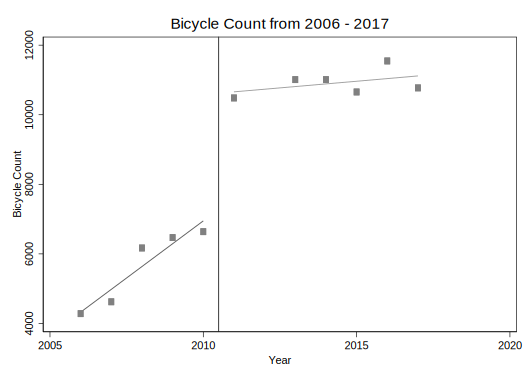

In [13]:
%%stata
//create solo graph of bicycle count per year 

grstyle init
grstyle set graphsize 6cm 10cm
twoway (lfit bicycle_count year if year <= 2010) (lfit bicycle_count year if year >= 2011)  ///
(scatter bicycle_count year), xline(2010.5) ytitle("Bicycle Count") title("Bicycle Count from 2006 - 2017") ///
legend(off) 